Adapted from [**PyG Tutorial**](https://pytorch-geometric.readthedocs.io/en/latest/)



In [6]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

# Graph Classification with Graph Neural Networks

We will have a closer look at how to apply Graph Neural Networks (GNNs) to the task of graph classification. Graph classification refers to the problem of classifiying entire graphs according to some type of labels.

The most common task for graph classification is molecular property prediction, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

# Dataset

[**TUDatasets**](https://chrsmrrs.github.io/datasets/) has a wide range of different graph classification datasets.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**

=== Description of the dataset === 

The MUTAG dataset consists of 188 chemical compounds divided into two 
classes according to their mutagenic effect on a bacterium. 

The chemical data was obtained form http://cdb.ics.uci.edu and converted 
to graphs, where vertices represent atoms and edges represent chemical 
bonds. Explicit hydrogen atoms have been removed and vertices are labeled
by atom type and edges by bond type (single, double, triple or aromatic).
Chemical data was processed using the Chemistry Development Kit (v1.4).

In [7]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [8]:
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset provides **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

The first graph object of the dataset comes with **17 nodes (with 7-dimensional feature vectors)** and **38 edges** (leading to an average node degree of 2.24).

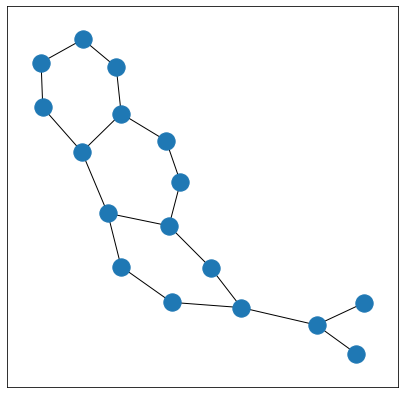

In [17]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [19]:
from torch_geometric.loader import DataLoader

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
from torch_geometric.nn import GraphConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [23]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7333, Test Acc: 0.8158
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 009, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 010, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 013, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 014, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 017, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 018, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 019, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.8133, Test Acc: 0.8421
Epoch: 021, Train Acc: 0.8000, Test Acc:

As one can see, our model reaches around 82% test accuracy. Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets.